<a href="https://colab.research.google.com/github/SamanMansoor/Data-Science/blob/main/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import os
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import numpy as np



In [6]:
# Load COVID-19 dataset
def load_dataset():
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_dir = '/content/covid/test'
    test_dir = '/content/covid/train'
    

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, test_generator

train_generator, test_generator = load_dataset()

Found 66 images belonging to 4 classes.
Found 251 images belonging to 4 classes.


In [7]:
import numpy as np

def prep_pixels(train_generator, test_generator):
    # convert from integers to floats
    train_samples = len(train_generator.filenames)
    test_samples = len(test_generator.filenames)

    train_shape = train_generator.image_shape
    test_shape = test_generator.image_shape

    train_data = np.zeros((train_samples, *train_shape), dtype='float32')
    test_data = np.zeros((test_samples, *test_shape), dtype='float32')

    for i in range(train_samples):
        train_data[i] = train_generator.next()[0][0] / 255.0
  
    for i in range(test_samples):
        test_data[i] = test_generator.next()[0][0] / 255.0

    return train_data, test_data

# prepare pixel data
train_norm, test_norm = prep_pixels(train_generator, test_generator)


Found 66 images belonging to 4 classes.
Found 251 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               540900    
                                                                 
 dense_7 (Dense)             (None, 4)                 404       
                                                                 
Total params: 541,624
Trainable params:

> 37.500
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 5408)              0         
                                                                 
 dense_10 (Dense)            (None, 100)               540900    
                                                                 
 dense_11 (Dense)            (None, 4)                 404       
                                                                 
Total params: 541,624
Trainable params: 541,624
Non-trainable params: 0
_______________________________________

> 50.000


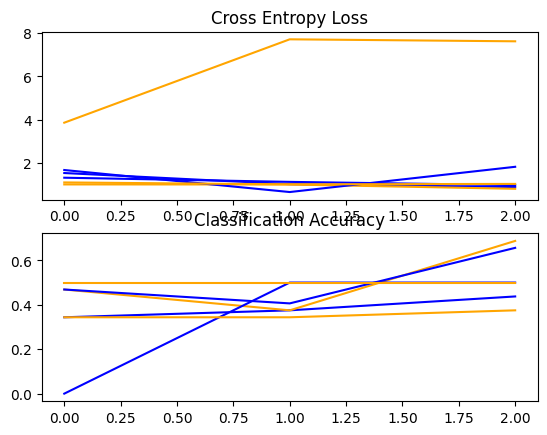

In [8]:

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax'))  # Update the number of units to 4
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



# Train and evaluate the model
def train_and_evaluate_model(train_generator, test_generator, n_folds=3):
    scores, histories = [], []
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(train_generator):
        model = define_model()
        train_batch = next(train_generator)
        test_batch = next(train_generator)
        trainX, trainY = train_batch[0], train_batch[1]
        testX, testY = test_batch[0], test_batch[1]
        history = model.fit(trainX, trainY, epochs=3, batch_size=32, validation_data=(testX, testY), verbose=0)
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        scores.append(acc)
        histories.append(history)
    return scores, histories

# Plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()


# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  pyplot.boxplot(scores)
  pyplot.show()


# Run the test harness
def run_test_harness():
    train_generator, test_generator = load_dataset()
    scores, histories = train_and_evaluate_model(train_generator, test_generator)
    summarize_diagnostics(histories)

run_test_harness()
